In [14]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from tbparse import SummaryReader

In [70]:
logs = SummaryReader("runs/", pivot=True, extra_columns={'dir_name'})
logs_no_pivot = SummaryReader("runs/", pivot=False, extra_columns={'dir_name'})
params = pl.from_pandas(logs.hparams, nan_to_null=True)
scores = pl.from_pandas(logs.scalars, nan_to_null=True)
hparams = params.join(scores.select(pl.col("F-Score", "dir_name")), on='dir_name', how='inner')
hparams = hparams.select(pl.all().exclude("dir_name"), pl.col("dir_name").str.split("/").list.first())

# Convert plots
images = logs_no_pivot.images
size = np.array(images.iloc[0]["value"].shape)
images["value"] = images["value"].apply(lambda x: x.flatten())
plots = pl.from_pandas(images, nan_to_null=True)
num_rows = plots.shape[0]
plots = plots.select(pl.col("dir_name"), pl.col("step"), pl.col("tag"),
                     pl.col("value").reshape(tuple([num_rows, *size]), pl.Array).alias("value"))
plots = plots.pivot(values=["value"], columns=["tag"], index=["step", "dir_name"])

In [71]:
pl.Config.set_tbl_cols(100)
pl.Config.set_tbl_rows(100)


def get_model_settings(model_type: str) -> (pl.DataFrame, pl.DataFrame):
    model = hparams.filter(pl.col("model_settings").str.contains(model_type))
    non_null = model.select(pl.all().is_not_null().all()).row(0)
    model = model[:, non_null]
    different = model.select(pl.all().n_unique() > 1).row(0)
    diff = model[:, different].sort("F-Score", descending=True)
    iden = model.select(pl.all().n_unique() == 1).row(0)
    identical = model[:, iden].select(pl.all().exclude("dir_name", "F-Score")).limit(1)

    return diff, identical


def get_history(name: str) -> pl.DataFrame:
    data = scores.filter(pl.col("dir_name") == name)
    prs = plots.filter(pl.col("dir_name") == name)
    data = data.join(prs, on="step", how="inner")
    return data

In [72]:
unique, identical = get_model_settings("mamba")
print(identical)
unique

shape: (1, 27)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ act ┆ bea ┆ cau ┆ cen ┆ dat ┆ det ┆ ema ┆ fft ┆ hop ┆ ign ┆ mel ┆ mel ┆ min ┆ n_c ┆ n_m ┆ nor ┆ num ┆ pad ┆ pad ┆ pad ┆ pea ┆ pea ┆ sam ┆ sch ┆ spl ┆ tes ┆ tra │
│ iva ┆ ts  ┆ sal ┆ ter ┆ ase ┆ ect ┆ --- ┆ _si ┆ _si ┆ ore ┆ _ma ┆ _mi ┆ _sa ┆ las ┆ els ┆ mal ┆ _wo ┆ _an ┆ _mo ┆ _va ┆ k_m ┆ k_m ┆ ple ┆ edu ┆ its ┆ t_b ┆ in_ │
│ tio ┆ --- ┆ --- ┆ --- ┆ t_v ┆ _to ┆ f64 ┆ ze  ┆ ze  ┆ _be ┆ x   ┆ n   ┆ ve_ ┆ ses ┆ --- ┆ ize ┆ rke ┆ not ┆ de  ┆ lue ┆ ax_ ┆ ean ┆ _ra ┆ ler ┆ --- ┆ atc ┆ set │
│ n   ┆ f64 ┆ f64 ┆ f64 ┆ ers ┆ ler ┆     ┆ --- ┆ --- ┆ ats ┆ --- ┆ --- ┆ sco ┆ --- ┆ f64 ┆ --- ┆ rs  ┆ ati ┆ --- ┆ --- ┆ ran ┆ _ra ┆ te  ┆ --- ┆ str ┆ h_s ┆ --- │
│ --- ┆     ┆     ┆     ┆ ion ┆ anc ┆     ┆ f64 ┆ f64 ┆ --- ┆ f64 ┆ f64 ┆ re  ┆ f64 ┆     ┆ f64 ┆ --- ┆ ons ┆ str ┆ f64 ┆ ge  ┆ nge ┆ --- ┆ f64 ┆     ┆ ize ┆ str │
│

batch_size,dropout,epochs,flux,learning_rate,mapping,min_test_score,model_settings,n_layers,num_channels,onset_cooldown,pr_points,time_shift,weight_decay,F-Score,dir_name
f64,f64,f64,f64,f64,str,f64,str,f64,f64,f64,f64,f64,f64,f64,str
4.0,0.1,20.0,0.0,0.0001,"""THREE_CLASS_STANDARD""",0.54,"""mamba""",3.0,16.0,0.021,1000.0,0.015,0.00001,0.455403,"""Jun10_17-58-15_seppel-liemarce"""
16.0,0.1,20.0,1.0,0.0001,"""Three class standard""",0.48,"""mamba_fast""",5.0,32.0,0.021,1000.0,0.02,0.00001,0.434372,"""Jun19_13-16-07_seppel-liemarce"""
16.0,0.1,20.0,0.0,0.0001,"""Three class standard""",0.48,"""mamba_fast""",3.0,16.0,0.021,1000.0,0.02,0.00001,0.139301,"""Jun25_07-53-16_seppel-liemarce"""
24.0,0.1,20.0,1.0,0.0001,"""Three class standard""",0.48,"""mamba_fast""",5.0,16.0,0.021,200.0,0.025,0.00001,0.116948,"""Jun23_17-34-02_seppel-liemarce"""
24.0,0.1,20.0,1.0,0.0001,"""Three class standard""",0.48,"""mamba_fast""",10.0,16.0,0.021,200.0,0.025,0.00001,0.052223,"""Jun22_16-25-42_seppel-liemarce"""
32.0,0.3,30.0,0.0,0.00005,"""THREE_CLASS_STANDARD""",0.54,"""mamba""",3.0,16.0,0.02,1000.0,0.015,0.0,0.04605,"""Jun08_13-22-15_seppel-liemarce"""
16.0,0.1,20.0,1.0,0.0001,"""Three class standard""",0.48,"""mamba_fast""",5.0,32.0,0.021,1000.0,0.02,0.00001,0.045436,"""Jun25_14-54-59_seppel-liemarce"""


In [84]:
unique, identical = get_model_settings("attention")
print(identical)
unique

shape: (1, 26)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ act ┆ bea ┆ cau ┆ cen ┆ det ┆ dro ┆ ema ┆ fft ┆ hop ┆ ign ┆ mel ┆ mel ┆ min ┆ mod ┆ n_c ┆ n_m ┆ nor ┆ num ┆ pad ┆ pad ┆ pea ┆ pea ┆ sam ┆ sch ┆ spl ┆ tra │
│ iva ┆ ts  ┆ sal ┆ ter ┆ ect ┆ pou ┆ --- ┆ _si ┆ _si ┆ ore ┆ _ma ┆ _mi ┆ _sa ┆ el_ ┆ las ┆ els ┆ mal ┆ _wo ┆ _mo ┆ _va ┆ k_m ┆ k_m ┆ ple ┆ edu ┆ its ┆ in_ │
│ tio ┆ --- ┆ --- ┆ --- ┆ _to ┆ t   ┆ f64 ┆ ze  ┆ ze  ┆ _be ┆ x   ┆ n   ┆ ve_ ┆ set ┆ ses ┆ --- ┆ ize ┆ rke ┆ de  ┆ lue ┆ ax_ ┆ ean ┆ _ra ┆ ler ┆ --- ┆ set │
│ n   ┆ f64 ┆ f64 ┆ f64 ┆ ler ┆ --- ┆     ┆ --- ┆ --- ┆ ats ┆ --- ┆ --- ┆ sco ┆ tin ┆ --- ┆ f64 ┆ --- ┆ rs  ┆ --- ┆ --- ┆ ran ┆ _ra ┆ te  ┆ --- ┆ str ┆ --- │
│ --- ┆     ┆     ┆     ┆ anc ┆ f64 ┆     ┆ f64 ┆ f64 ┆ --- ┆ f64 ┆ f64 ┆ re  ┆ gs  ┆ f64 ┆     ┆ f64 ┆ --- ┆ str ┆ f64 ┆ ge  ┆ nge ┆ --- ┆ f64 ┆     ┆ str │
│ str ┆     ┆     ┆     ┆ e   ┆     ┆

batch_size,context_size,dataset_version,epochs,flux,learning_rate,mapping,min_test_score,num_attention_blocks,num_channels,num_heads,onset_cooldown,pad_annotations,test_batch_size,time_shift,F-Score,dir_name
f64,f64,str,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
16.0,200.0,"""L""",20.0,1.0,0.0001,"""THREE_CLASS_STANDARD""",0.54,5.0,24.0,8.0,0.021,1.0,1.0,0.015,0.492189,"""Jun13_10-57-29_seppel-liemarce"""
16.0,200.0,"""L""",20.0,1.0,0.0001,"""THREE_CLASS_STANDARD""",0.54,5.0,32.0,8.0,0.021,1.0,1.0,0.015,0.482672,"""Jun14_09-33-24_seppel-liemarce"""
4.0,200.0,"""L""",20.0,0.0,0.0001,"""THREE_CLASS_STANDARD""",0.54,5.0,16.0,8.0,0.021,1.0,1.0,0.015,0.458652,"""Jun11_13-54-21_seppel-liemarce"""
16.0,200.0,"""L""",20.0,1.0,0.0001,"""Three class standard""",0.48,5.0,24.0,8.0,0.021,1.0,1.0,0.02,0.393078,"""Jun17_15-04-11_seppel-liemarce"""
4.0,200.0,"""S""",20.0,0.0,0.0001,"""THREE_CLASS_STANDARD""",0.54,5.0,32.0,8.0,0.021,1.0,1.0,0.015,0.248427,"""Jun11_06-49-13_seppel-liemarce"""
8.0,200.0,"""L""",20.0,1.0,0.0001,"""THREE_CLASS_STANDARD""",0.54,5.0,24.0,8.0,0.021,1.0,1.0,0.015,0.233853,"""Jun12_07-38-49_seppel-liemarce"""
128.0,50.0,"""L""",30.0,0.0,0.0004,"""THREE_CLASS_STANDARD""",0.54,1.0,32.0,4.0,0.02,0.0,10.0,0.015,0.206779,"""Jun05_14-40-09_seppel-liemarce"""


In [74]:
unique, identical = get_model_settings("cnn")
print(identical)
unique

shape: (1, 25)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ act ┆ bea ┆ cau ┆ cen ┆ det ┆ dro ┆ ema ┆ fft ┆ hop ┆ ign ┆ mel ┆ mel ┆ min ┆ n_c ┆ n_m ┆ nor ┆ num ┆ pad ┆ pad ┆ pea ┆ pea ┆ sam ┆ sch ┆ spl ┆ tra │
│ iva ┆ ts  ┆ sal ┆ ter ┆ ect ┆ pou ┆ --- ┆ _si ┆ _si ┆ ore ┆ _ma ┆ _mi ┆ _sa ┆ las ┆ els ┆ mal ┆ _wo ┆ _mo ┆ _va ┆ k_m ┆ k_m ┆ ple ┆ edu ┆ its ┆ in_ │
│ tio ┆ --- ┆ --- ┆ --- ┆ _to ┆ t   ┆ f64 ┆ ze  ┆ ze  ┆ _be ┆ x   ┆ n   ┆ ve_ ┆ ses ┆ --- ┆ ize ┆ rke ┆ de  ┆ lue ┆ ax_ ┆ ean ┆ _ra ┆ ler ┆ --- ┆ set │
│ n   ┆ f64 ┆ f64 ┆ f64 ┆ ler ┆ --- ┆     ┆ --- ┆ --- ┆ ats ┆ --- ┆ --- ┆ sco ┆ --- ┆ f64 ┆ --- ┆ rs  ┆ --- ┆ --- ┆ ran ┆ _ra ┆ te  ┆ --- ┆ str ┆ --- │
│ --- ┆     ┆     ┆     ┆ anc ┆ f64 ┆     ┆ f64 ┆ f64 ┆ --- ┆ f64 ┆ f64 ┆ re  ┆ f64 ┆     ┆ f64 ┆ --- ┆ str ┆ f64 ┆ ge  ┆ nge ┆ --- ┆ f64 ┆     ┆ str │
│ str ┆     ┆     ┆     ┆ e   ┆     ┆     ┆     ┆     ┆ f64 ┆     ┆     ┆

batch_size,dataset_version,epochs,flux,learning_rate,mapping,min_test_score,model_settings,num_channels,onset_cooldown,pad_annotations,test_batch_size,time_shift,F-Score,dir_name
f64,str,f64,f64,f64,str,f64,str,f64,f64,f64,f64,f64,f64,str
16.0,"""L""",20.0,1.0,0.0001,"""THREE_CLASS_STANDARD""",0.54,"""cnn_attention""",24.0,0.021,1.0,1.0,0.015,0.492189,"""Jun13_10-57-29_seppel-liemarce"""
512.0,"""L""",30.0,1.0,0.0001,"""THREE_CLASS_STANDARD""",0.54,"""cnn""",16.0,0.02,0.0,10.0,0.015,0.487235,"""Jun04_19-26-40_seppel-liemarce"""
16.0,"""L""",20.0,1.0,0.0001,"""THREE_CLASS_STANDARD""",0.54,"""cnn_attention""",32.0,0.021,1.0,1.0,0.015,0.482672,"""Jun14_09-33-24_seppel-liemarce"""
512.0,"""L""",20.0,1.0,0.0001,"""THREE_CLASS_STANDARD""",0.54,"""cnn""",16.0,0.02,1.0,1.0,0.015,0.462143,"""Jun10_09-14-54_seppel-liemarce"""
4.0,"""L""",20.0,0.0,0.0001,"""THREE_CLASS_STANDARD""",0.54,"""cnn_attention""",16.0,0.021,1.0,1.0,0.015,0.458652,"""Jun11_13-54-21_seppel-liemarce"""
16.0,"""L""",20.0,1.0,0.0001,"""Three class standard""",0.48,"""cnn_attention""",24.0,0.021,1.0,1.0,0.02,0.393078,"""Jun17_15-04-11_seppel-liemarce"""
512.0,"""L""",20.0,1.0,0.0001,"""THREE_CLASS_STANDARD""",0.54,"""cnn""",16.0,0.02,1.0,1.0,0.025,0.267671,"""Jun09_16-46-27_seppel-liemarce"""
4.0,"""S""",20.0,0.0,0.0001,"""THREE_CLASS_STANDARD""",0.54,"""cnn_attention""",32.0,0.021,1.0,1.0,0.015,0.248427,"""Jun11_06-49-13_seppel-liemarce"""
8.0,"""L""",20.0,1.0,0.0001,"""THREE_CLASS_STANDARD""",0.54,"""cnn_attention""",24.0,0.021,1.0,1.0,0.015,0.233853,"""Jun12_07-38-49_seppel-liemarce"""


In [90]:
best = unique.select("dir_name").row(0)[0]
history = get_history(best)
pr_curve = history.select(pl.col("Validation/PR-Curve/")).row(-1)[0]

(-0.5, 639.5, 479.5, -0.5)

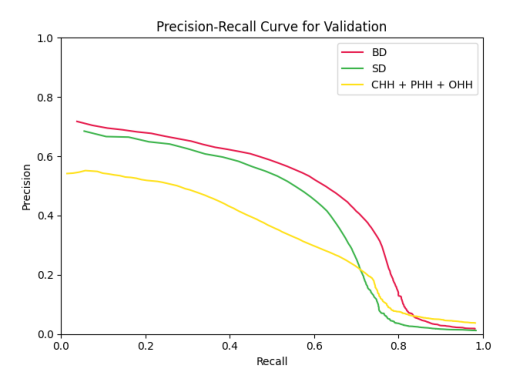

In [91]:
plt.imshow(pr_curve)
plt.axis("off")